In [1]:
import os
import sys
from glob import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from utils import label_map_util
from utils import visualization_utils as vis_util
import random

%matplotlib inline

In [2]:
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [14]:
## Test model
# PATH_TO_GRAPH = r'models/rcnn_resnet101/frozen_inference_graph.pb'
# PATH_TO_GRAPH = r'models/rcnn/frozen_inference_graph.pb'
PATH_TO_GRAPH = r'models/ssd_inception_v2_coco_2017_11_17/real/frozen_inference_graph.pb' ## load SSD trained on udacity's parking lot images
PATH_TO_LABELS = r'data/udacity_label_map.pbtxt'
NUM_CLASSES = 4

In [15]:
detection_graph = load_graph(PATH_TO_GRAPH)

In [16]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'Green'}, 2: {'id': 2, 'name': 'Red'}, 3: {'id': 3, 'name': 'Yellow'}, 4: {'id': 4, 'name': 'off'}}


In [17]:
IMAGE_SIZE = (12, 8)

SCORES
[0.9920993  0.03310702 0.01789276 0.00640893 0.00458912 0.00386292
 0.00340613 0.00287998 0.00287274 0.00286141]
CLASSES
[1. 1. 1. 1. 1. 1. 4. 3. 1. 1.]


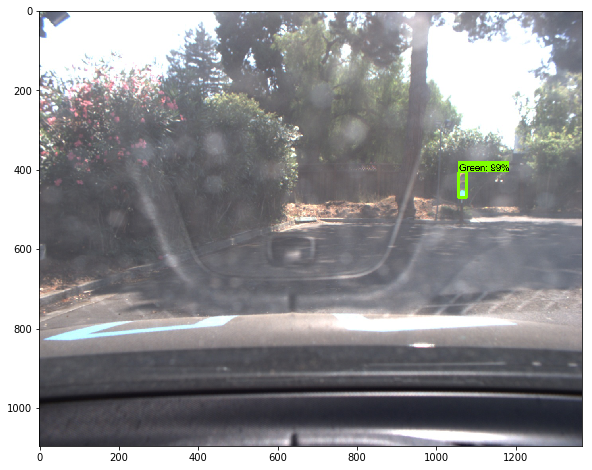

SCORES
[0.82698506 0.00582182 0.00424779 0.00354393 0.00321858 0.00317324
 0.00308929 0.00296567 0.00292466 0.00289835]
CLASSES
[1. 2. 1. 3. 4. 3. 4. 1. 4. 2.]


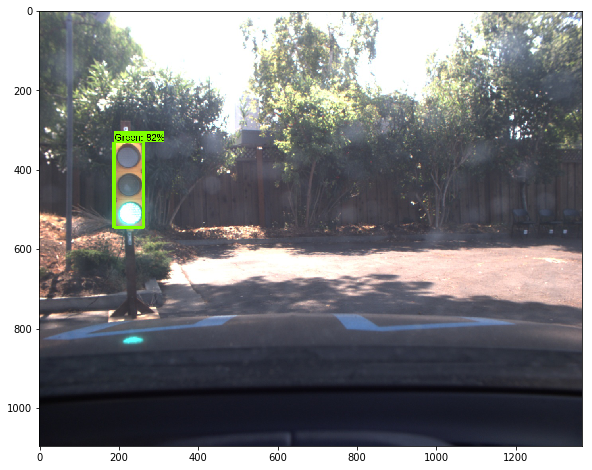

SCORES
[0.8280086  0.00419327 0.00363634 0.00360403 0.00335079 0.00334146
 0.00322413 0.00312555 0.00309179 0.00309152]
CLASSES
[2. 4. 2. 1. 4. 4. 1. 1. 4. 2.]


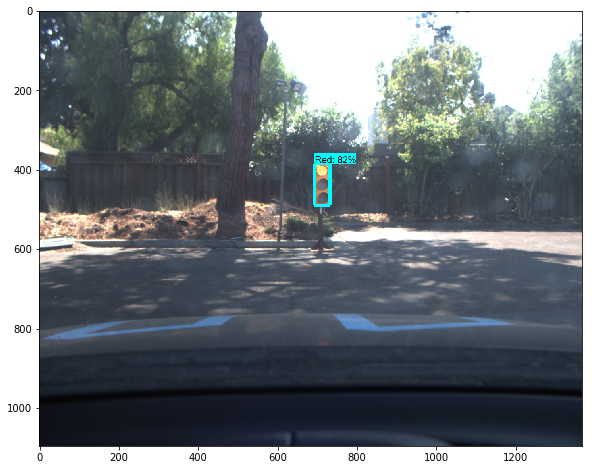

SCORES
[0.99502987 0.00340135 0.00332762 0.00316276 0.00301659 0.00296099
 0.00294143 0.00280805 0.00266164 0.00254427]
CLASSES
[1. 4. 4. 3. 2. 1. 1. 4. 1. 4.]


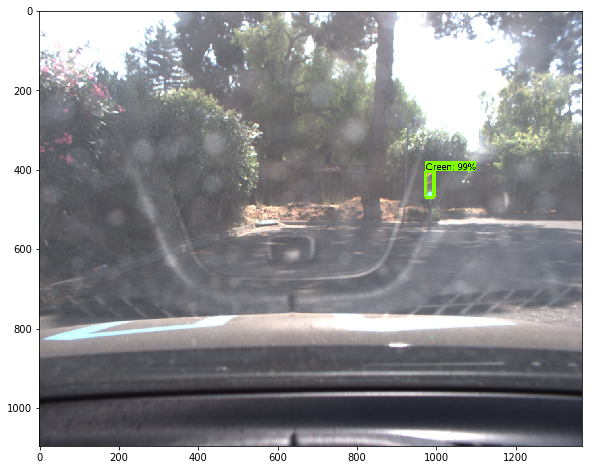

SCORES
[0.99479985 0.00430016 0.00374511 0.0028375  0.00282278 0.00273084
 0.00268752 0.00267637 0.00265524 0.00260415]
CLASSES
[1. 4. 4. 4. 3. 1. 4. 4. 4. 4.]


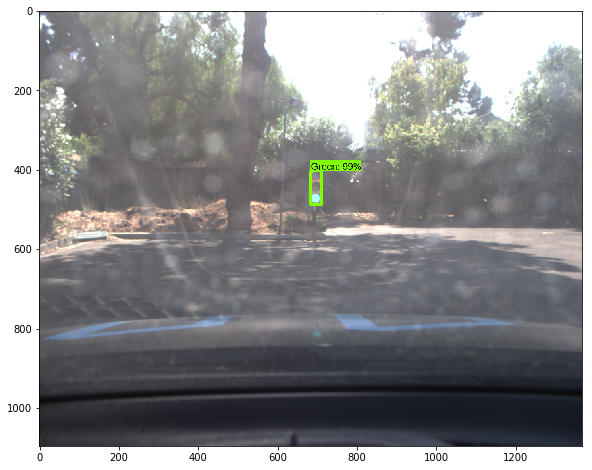

SCORES
[0.43712014 0.00617532 0.00554343 0.00498871 0.00453047 0.00405434
 0.00378446 0.00374355 0.00366994 0.00352203]
CLASSES
[3. 1. 1. 1. 4. 4. 2. 4. 3. 1.]


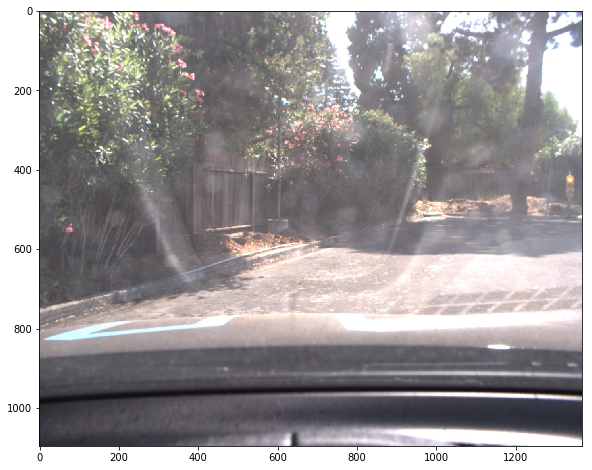

SCORES
[0.9794519  0.00532748 0.00365924 0.0031405  0.00313099 0.00304583
 0.00301458 0.00300412 0.0028622  0.0028263 ]
CLASSES
[1. 1. 4. 4. 4. 2. 1. 4. 1. 3.]


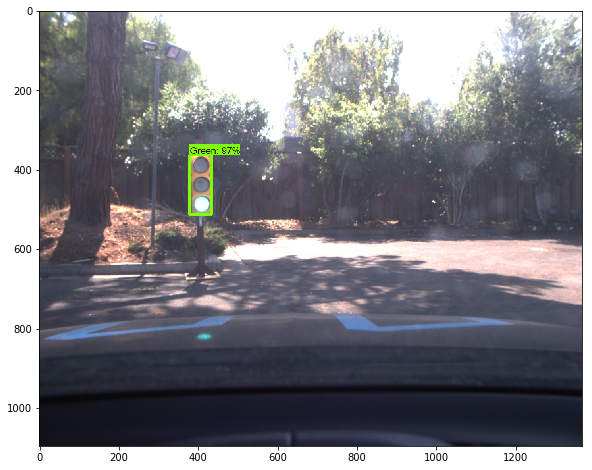

SCORES
[0.23173892 0.00361462 0.00333729 0.00328023 0.00316576 0.00307192
 0.00294066 0.0028198  0.00272168 0.00270268]
CLASSES
[2. 4. 4. 3. 4. 3. 3. 3. 4. 1.]


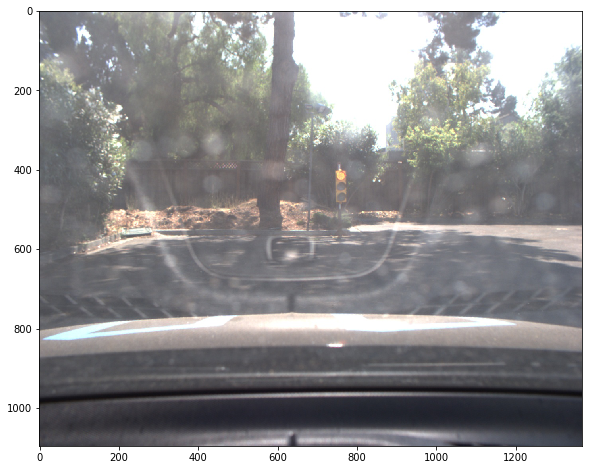

SCORES
[0.97950405 0.00305642 0.00300046 0.00299291 0.00283254 0.00282942
 0.00282785 0.00277845 0.00272599 0.0026352 ]
CLASSES
[1. 4. 4. 2. 1. 2. 4. 2. 1. 4.]


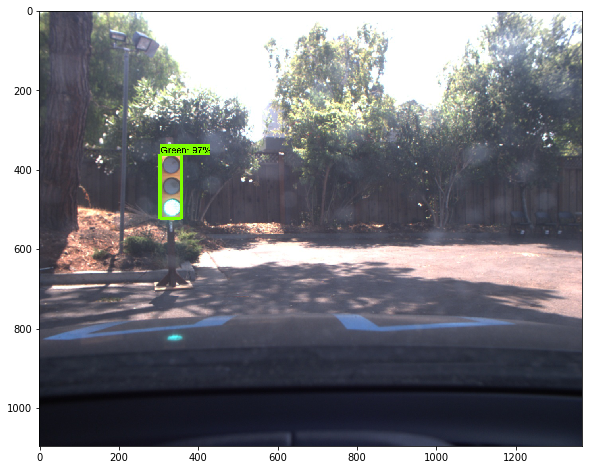

SCORES
[0.98174554 0.00324173 0.003236   0.00310991 0.00304027 0.00288916
 0.00282544 0.00278586 0.00273187 0.00272577]
CLASSES
[1. 4. 4. 3. 2. 4. 1. 4. 4. 3.]


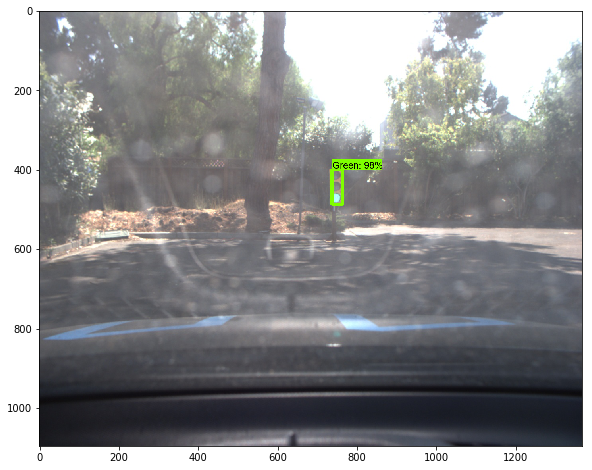

SCORES
[0.09065165 0.02052034 0.00575884 0.00553569 0.00451612 0.0039924
 0.00395573 0.00394549 0.00329607 0.00327543]
CLASSES
[2. 3. 1. 1. 1. 4. 1. 1. 1. 4.]


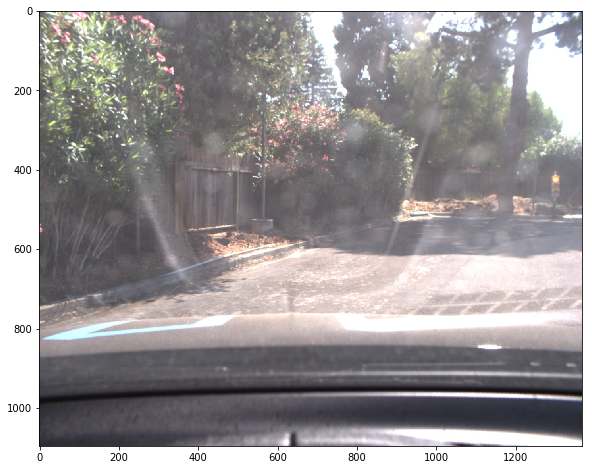

In [18]:
PATH_TO_IMGS = r'data/udacity_testarea_rgb'
TEST_IMGS = glob(os.path.join(PATH_TO_IMGS, r'*.jpg'))
random.shuffle(TEST_IMGS)

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detect_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detect_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detect_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for idx, img_path in enumerate(TEST_IMGS):
            random.shuffle(TEST_IMGS)
            image = Image.open(img_path)
            image_np = load_image_into_numpy_array(image)
            image_expanded = np.expand_dims(image_np, axis=0)
            
            (boxes, scores, classes, num) = sess.run(
                [detect_boxes, detect_scores, detect_classes, num_detections],
                feed_dict={image_tensor: image_expanded})
            
            print('SCORES')
            print(scores[0])
            print('CLASSES')
            print(classes[0])
            
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, 
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()
            
            if idx == 10:
                break

In [11]:
PATH_TO_GRAPH = r'models/ssd_inception_v2_coco_2017_11_17/sim/frozen_inference_graph.pb' ## load SSD trained on udacity's simulator images
detection_graph = load_graph(PATH_TO_GRAPH)

SCORES
[0.9311242  0.87294424 0.8256039  0.015119   0.01314687 0.01237108
 0.01204083 0.01197505 0.01176061 0.01153577]
CLASSES
[2. 2. 2. 2. 2. 1. 2. 4. 1. 2.]


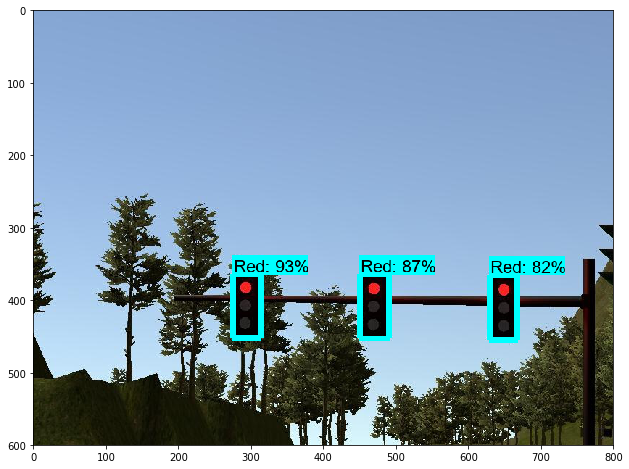

SCORES
[0.9995977  0.9994444  0.99894315 0.01432048 0.01238852 0.01005678
 0.00997406 0.00906177 0.00785934 0.00777345]
CLASSES
[1. 1. 1. 1. 1. 1. 1. 4. 2. 3.]


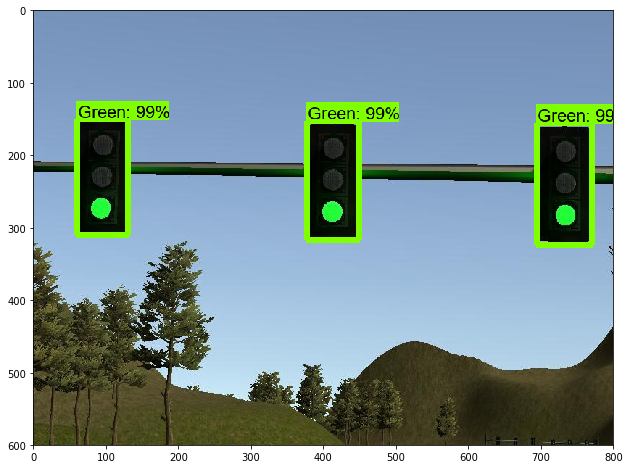

SCORES
[0.71768135 0.4395664  0.39926472 0.01360636 0.01199817 0.01118802
 0.01116698 0.01076292 0.01066196 0.0104318 ]
CLASSES
[2. 2. 2. 2. 1. 2. 2. 3. 3. 1.]


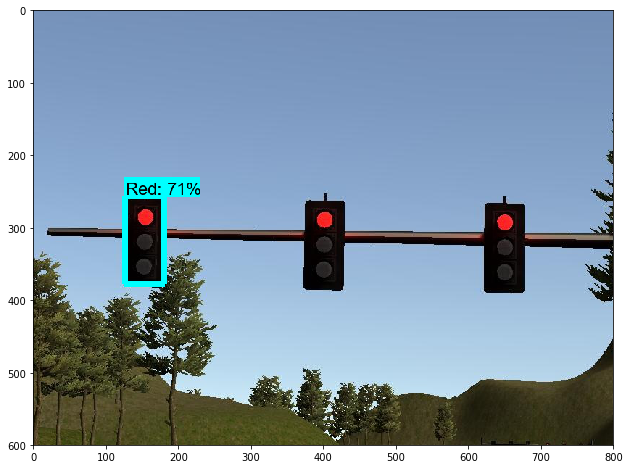

SCORES
[0.99909246 0.99832743 0.9959182  0.02367916 0.01970926 0.01599048
 0.01224448 0.00993377 0.0082182  0.00813438]
CLASSES
[2. 2. 2. 1. 1. 2. 4. 2. 2. 2.]


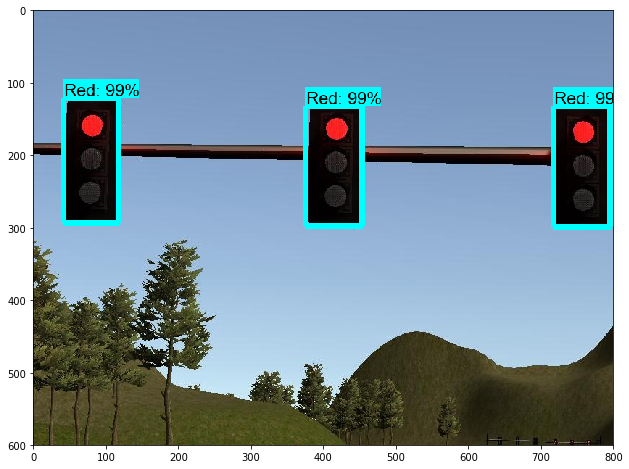

SCORES
[0.71768135 0.4395664  0.39926472 0.01360636 0.01199817 0.01118802
 0.01116698 0.01076292 0.01066196 0.0104318 ]
CLASSES
[2. 2. 2. 2. 1. 2. 2. 3. 3. 1.]


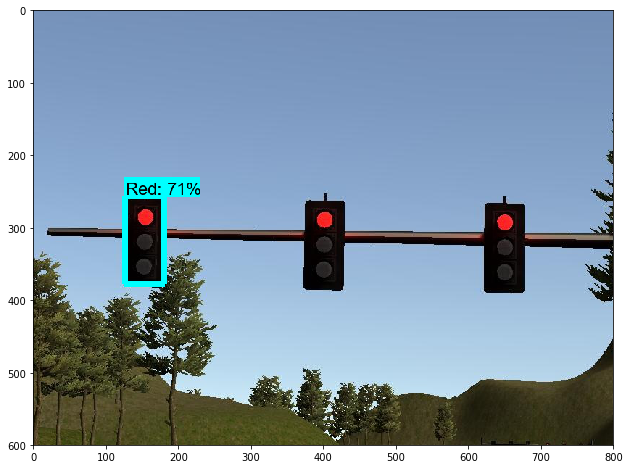

SCORES
[0.9990995  0.9960949  0.99446577 0.05293291 0.01446467 0.01010382
 0.00934197 0.00919118 0.00899047 0.0079256 ]
CLASSES
[1. 1. 1. 1. 4. 2. 4. 3. 1. 4.]


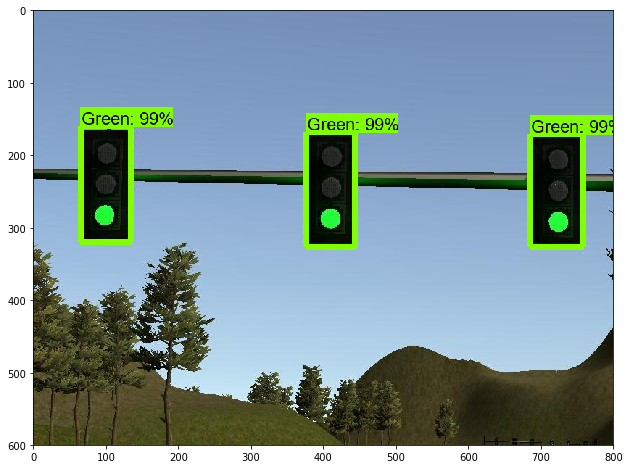

SCORES
[0.98980683 0.98901576 0.986008   0.01137603 0.01069552 0.01044242
 0.00896122 0.00887686 0.00878123 0.00865825]
CLASSES
[1. 1. 1. 3. 1. 2. 3. 4. 1. 3.]


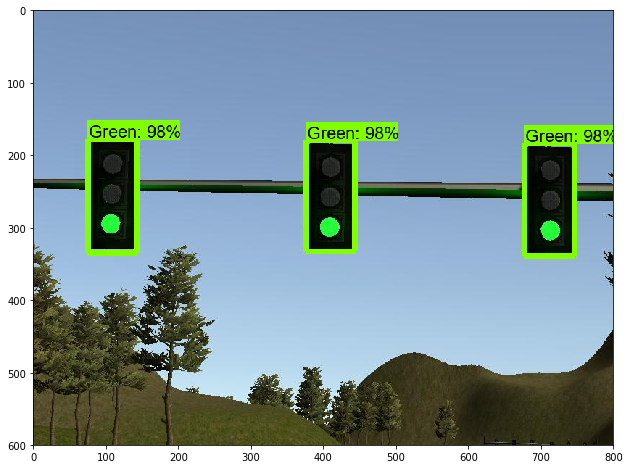

SCORES
[0.902505   0.8689761  0.16743578 0.02138464 0.01981833 0.01877438
 0.01474021 0.01434544 0.01406176 0.01324513]
CLASSES
[1. 1. 1. 1. 3. 3. 1. 1. 3. 4.]


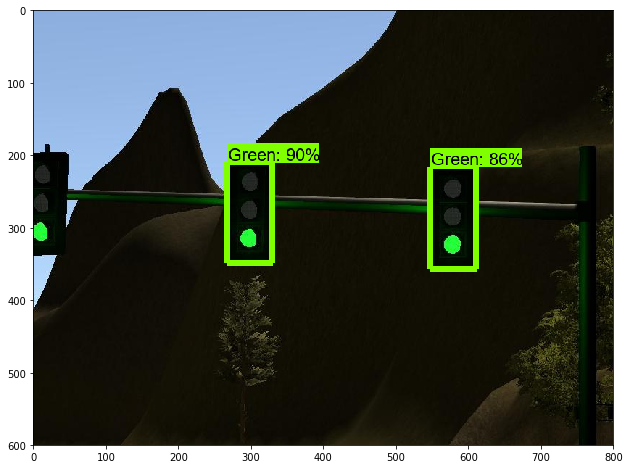

SCORES
[0.9029372  0.79887044 0.44652316 0.03203271 0.01907015 0.01522485
 0.01269204 0.01238607 0.01199932 0.01165651]
CLASSES
[2. 2. 2. 1. 1. 3. 1. 2. 3. 4.]


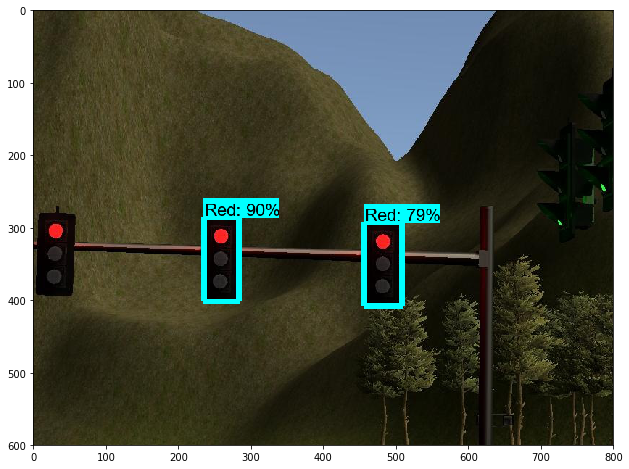

SCORES
[0.8041556  0.43622905 0.20337996 0.08079829 0.06889348 0.04761556
 0.02718936 0.02462064 0.0245362  0.02168668]
CLASSES
[2. 2. 2. 2. 2. 2. 2. 4. 2. 2.]


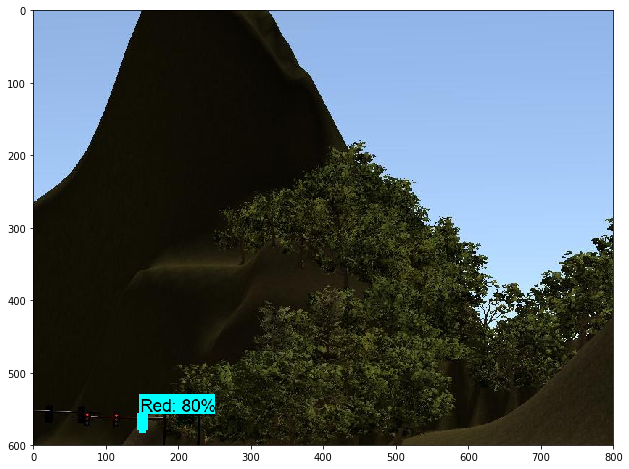

SCORES
[0.01296626 0.0127154  0.01224732 0.01217153 0.01198285 0.01168523
 0.01131799 0.01093048 0.01071425 0.01060283]
CLASSES
[2. 2. 2. 2. 2. 3. 3. 2. 2. 2.]


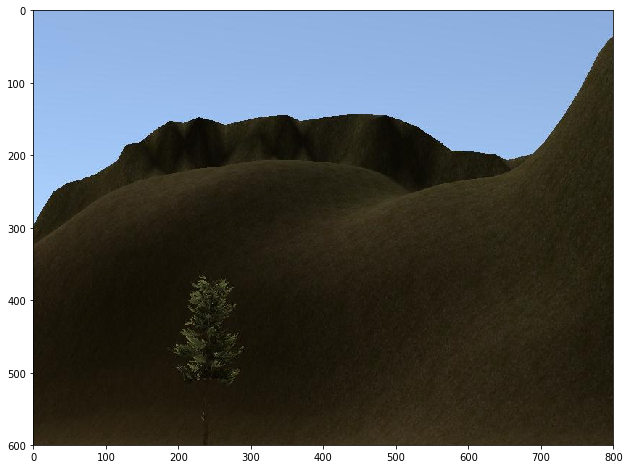

In [12]:
PATH_TO_IMGS = r'data/simulator_dataset_rgb'
subfolder = ['Green', 'Red', 'Yellow', 'Unknown']
TEST_IMGS = []
for i in subfolder:
    TEST_IMGS += glob(os.path.join(os.path.join(PATH_TO_IMGS, i), r'*.jpg'))
random.shuffle(TEST_IMGS)

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detect_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detect_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detect_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for idx, img_path in enumerate(TEST_IMGS):
            image = Image.open(img_path)
            image_np = load_image_into_numpy_array(image)
            image_expanded = np.expand_dims(image_np, axis=0)
            
            (boxes, scores, classes, num) = sess.run(
                [detect_boxes, detect_scores, detect_classes, num_detections],
                feed_dict={image_tensor: image_expanded})
            
            print('SCORES')
            print(scores[0])
            print('CLASSES')
            print(classes[0])
            
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, 
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()
            
            if idx == 10:
                break